In [1]:
import numpy as np
import pandas as pd
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.layers import Dropout, Dense, GlobalAveragePooling2D, Conv2D, MaxPooling2D, BatchNormalization
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import AUC
import matplotlib.pyplot as plt
import random
import os
from tensorflow.keras import layers
from keras.regularizers import l2
from keras_preprocessing.image import load_img, img_to_array

In [2]:
df = pd.read_csv("jldp-wi-images-3-8-2023.csv")
df.head()

,project_id,deployment_id,image_id,filename,location,is_blank,identified_by,wi_taxon_id,class,order,...,age,sex,animal_recognizable,individual_id,individual_animal_notes,behavior,highlighted,markings,cv_confidence,license
0,2004085,Percos Boat Cam,2ce50250-84ca-4a83-b263-2f24bf522d0d,boat_14may22_10771.JPG,gs://145625598251_2004085_882_project_ecotone_...,0,Andrea Gomez,aaf3b049-36e6-46dd-9a07-8a580e9618b7,Mammalia,Carnivora,...,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,CC0
1,2004085,Percos Boat Cam,cad9d5ae-503c-436d-a81e-4cbc322f2492,boat_14may22_10776.JPG,gs://145625598251_2004085_882_project_ecotone_...,0,Andrea Gomez,3184697f-51ad-4608-9a28-9edb5500159c,Mammalia,Carnivora,...,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,CC0
2,2004085,Percos Boat Cam,3b45f93b-1539-4a7a-8577-8de6a12015e1,boat_14may22_09239.JPG,gs://145625598251_2004085_882_project_ecotone_...,0,Andrea Gomez,aaf3b049-36e6-46dd-9a07-8a580e9618b7,Mammalia,Carnivora,...,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,CC0
3,2004085,Percos Boat Cam,85f21059-cb89-48bf-98c6-30440c02f0f5,boat_14may22_11042.JPG,gs://145625598251_2004085_882_project_ecotone_...,0,Andrea Gomez,aaf3b049-36e6-46dd-9a07-8a580e9618b7,Mammalia,Carnivora,...,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,CC0
4,2004085,Percos Boat Cam,ed0e7715-c052-4599-a366-bd50134aca77,boat_14may22_11046.JPG,gs://145625598251_2004085_882_project_ecotone_...,0,Andrea Gomez,aaf3b049-36e6-46dd-9a07-8a580e9618b7,Mammalia,Carnivora,...,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,CC0


In [3]:
df.shape

(24365, 27)

In [4]:
df.columns

Index(['project_id', 'deployment_id', 'image_id', 'filename', 'location',
       'is_blank', 'identified_by', 'wi_taxon_id', 'class', 'order', 'family',
       'genus', 'species', 'common_name', 'uncertainty', 'timestamp',
       'number_of_objects', 'age', 'sex', 'animal_recognizable',
       'individual_id', 'individual_animal_notes', 'behavior', 'highlighted',
       'markings', 'cv_confidence', 'license'],
      dtype='object')

In [5]:
top_19 = df['common_name'].value_counts()[:19].index

In [6]:
df_19 = df[df['common_name'].isin(top_19)]

In [7]:
file = "gs://145625598251_2004085_882_project_ecotone__main/deployment/2139508/prod/directUpload/00eb6272-fcc0-41da-8520-0ccfe6189a54.JPG"
file.split('/')[-1]

'00eb6272-fcc0-41da-8520-0ccfe6189a54.JPG'

In [8]:
df['filename'] = df['location'].str.split('/').str.get(-1)


In [9]:
df['filename'].values

array(['2ce50250-84ca-4a83-b263-2f24bf522d0d.JPG',
       'cad9d5ae-503c-436d-a81e-4cbc322f2492.JPG',
       '3b45f93b-1539-4a7a-8577-8de6a12015e1.JPG', ...,
       '2a607876-db36-4503-9118-7976f3f0c01c.JPG',
       '14853b1d-d7b9-48a1-ab13-e1081ed66b92.JPG',
       'bea39d37-e667-48b3-90ca-dd7bc667e081.JPG'], dtype=object)

In [10]:
df['filename'].to_csv('filenames.txt', index=False, header=False, sep='\t')

In [11]:
# Read the content of labelled_images.txt into a list
with open('labelled_images.txt', 'r') as file:
    labelled_images_list = [line.strip() for line in file]

# Filter the DataFrame to keep rows with filenames in labelled_images_list
filtered_df = df[df['filename'].isin(labelled_images_list)]

In [12]:
df_en = filtered_df[['filename','class', 'order', 'family',
       'genus', 'species', 'common_name','number_of_objects','animal_recognizable']]

df_en.head()

,filename,class,order,family,genus,species,common_name,number_of_objects,animal_recognizable
0,2ce50250-84ca-4a83-b263-2f24bf522d0d.JPG,Mammalia,Carnivora,Canidae,Canis,latrans,Coyote,1,NaN
1,cad9d5ae-503c-436d-a81e-4cbc322f2492.JPG,Mammalia,Carnivora,Canidae,NaN,NaN,Canine Family,1,NaN
2,3b45f93b-1539-4a7a-8577-8de6a12015e1.JPG,Mammalia,Carnivora,Canidae,Canis,latrans,Coyote,1,NaN
3,85f21059-cb89-48bf-98c6-30440c02f0f5.JPG,Mammalia,Carnivora,Canidae,Canis,latrans,Coyote,1,NaN
4,ed0e7715-c052-4599-a366-bd50134aca77.JPG,Mammalia,Carnivora,Canidae,Canis,latrans,Coyote,1,NaN


In [13]:
df_en.head()

,filename,class,order,family,genus,species,common_name,number_of_objects,animal_recognizable
0,2ce50250-84ca-4a83-b263-2f24bf522d0d.JPG,Mammalia,Carnivora,Canidae,Canis,latrans,Coyote,1,NaN
1,cad9d5ae-503c-436d-a81e-4cbc322f2492.JPG,Mammalia,Carnivora,Canidae,NaN,NaN,Canine Family,1,NaN
2,3b45f93b-1539-4a7a-8577-8de6a12015e1.JPG,Mammalia,Carnivora,Canidae,Canis,latrans,Coyote,1,NaN
3,85f21059-cb89-48bf-98c6-30440c02f0f5.JPG,Mammalia,Carnivora,Canidae,Canis,latrans,Coyote,1,NaN
4,ed0e7715-c052-4599-a366-bd50134aca77.JPG,Mammalia,Carnivora,Canidae,Canis,latrans,Coyote,1,NaN


In [14]:
# df_en.loc[:, 'animal_recognizable'] = df_en['animal_recognizable'].astype(str)

In [15]:
df_nona = df_en.dropna(subset=['common_name'])

In [16]:
df_nona = df_nona[df_nona['common_name']!= 'No CV Result']

In [17]:
df_nona['common_name'].value_counts()[:25]

common_name
Coyote                   7941
Wild Boar                3288
Mule Deer                2084
Animal                   1981
Domestic Cattle          1229
Bird                      873
Western fence lizard      662
Mammal                    580
Canine Family             526
Turkey Vulture            355
California Gull           256
Rodent                    254
Mallard                   245
Great Blue Heron          209
Western Gull              206
Carnivorous Mammal        177
Canis Species             133
Lizards and Snakes        128
Cervidae Family            96
Western Gray Squirrel      96
Common Raven               95
Corvus Species             78
Cetartiodactyla Order      68
American Black Bear        55
Snowy Plover               50
Name: count, dtype: int64

In [18]:
df_nona['common_name'].value_counts().sum()

22466

In [96]:
more_100 = df_nona['common_name'].value_counts()[:3].index

In [97]:
df_nona = df_nona[df_nona['common_name'].isin(more_100)]

# Image Data Generators

In [98]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(train_data['common_name']), y=train_data['common_name'])

In [99]:
# train_datagen = ImageDataGenerator(
#     rescale=1.0/255,
#     # rotation_range=35,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     # shear_range=0.2,
#     # zoom_range=0.2,
#     horizontal_flip=True,
#     # fill_mode='nearest'
# )

# train_datagen = ImageDataGenerator(
#     rescale=1.0/255,
#     width_shift_range=0.0,  # Set to zero to disable shifting
#     height_shift_range=0.0,  # Set to zero to disable shifting
#     fill_mode='constant',  # Use constant to perform zero-padding
#     cval=0  # Set the padding value to 0
# )

# Create an ImageDataGenerator with rescaling, zero-padding, and additional augmentations
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    width_shift_range=0.0,
    height_shift_range=0.0,
    fill_mode='constant',
    cval=0,
    rotation_range=20,  # Rotate images by up to 20 degrees
    zoom_range=0.2,     # Zoom in/out by up to 20%
    horizontal_flip=True,  # Flip images horizontally
    vertical_flip=True,    # Flip images vertically
    shear_range=0.2,       # Apply shear transformation
)

val_datagen = train_datagen

In [100]:
batch_size = 32

## Maintain Aspect Ratio

In [101]:
# 2. Perform stratified sampling to ensure the same categories in both sets
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, val_idx in splitter.split(df_nona, df_nona['common_name']):
    train_data = df_nona.iloc[train_idx]
    val_data = df_nona.iloc[val_idx]

In [120]:
from keras.preprocessing.image import ImageDataGenerator

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    directory="labelled_training",
    x_col="filename",
    y_col="common_name",
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode="categorical",
    class_weight=dict(enumerate(class_weights)),
    padding='same',  # Perform zero-padding
    shuffle=True  # Shuffle the data during training
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_data,
    directory="labelled_training",
    x_col="filename",
    y_col="common_name",
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode="categorical",
    padding='same',  # Perform zero-padding
    shuffle=True  # Shuffle the data during validation
)



Found 10650 validated image filenames belonging to 3 classes.
Found 2663 validated image filenames belonging to 3 classes.


In [121]:
# # Now, you can proceed with creating data generators as before
# train_generator = train_datagen.flow_from_dataframe(
#     dataframe=train_data,
#     directory="labelled_training",
#     x_col="filename",
#     y_col="common_name",
#     target_size=(224, 224),
#     batch_size=batch_size,
#     class_mode="categorical"
# )

# val_generator = val_datagen.flow_from_dataframe(
#     dataframe=val_data,
#     directory="labelled_training",
#     x_col="filename",
#     y_col="common_name",
#     target_size=(224, 224),
#     batch_size=batch_size,
#     class_mode="categorical"
# )

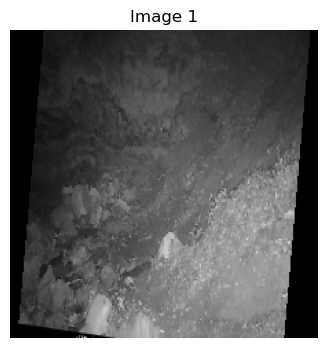

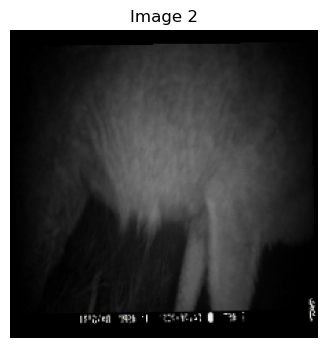

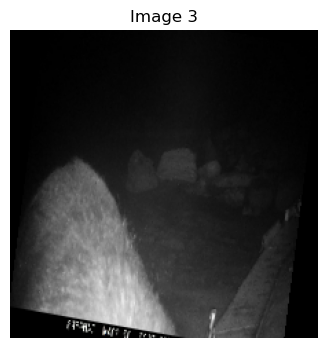

In [122]:
num_images_to_display = 1  # Set the number of images to preview

for i in range(num_images_to_display):
    x_batch, y_batch = next(val_generator)
    
    # Display the images in the batch
    for j in range(3):
        plt.figure(figsize=(4, 4))
        plt.imshow(x_batch[j])
        plt.title(f"Image {i * num_images_to_display + j + 1}")
        plt.axis('off')
        plt.show()

In [123]:
num_classes = df_nona['common_name'].nunique()

In [124]:
base_model = tf.keras.applications.EfficientNetB7(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3)  # Adjust input shape to match your images
)

# Freeze the layers of the base model
base_model.trainable = False
model = tf.keras.Sequential([base_model])

model.add(GlobalAveragePooling2D())
model.add(BatchNormalization())
model.add(Dropout(.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(.2))
# model.add(Dense(num_classes, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))  # Replace 'num_classes' with the number of classes in your classification task



In [125]:
# # LAYERS 
# additional_layers = [
#     layers.ZeroPadding2D(padding=(1, 1)),
#     layers.Conv2D(32, (3, 3), activation='relu',padding = 'same',kernel_regularizer=l2(0.002)),
#     layers.MaxPooling2D((2, 2),padding = 'same'),
#     layers.Conv2D(64, (3, 3), activation='relu',padding = 'same',kernel_regularizer=l2(0.002)),
#     layers.MaxPooling2D((2, 2),padding = 'same'),
#     layers.Conv2D(128, (3, 3), activation='relu',padding = 'same',kernel_regularizer=l2(0.002)),
#     layers.MaxPooling2D((2, 2),padding = 'same'),
#     layers.Conv2D(256, (3, 3), activation='relu',padding = 'same',kernel_regularizer=l2(0.002)),
#     layers.MaxPooling2D((2, 2),padding = 'same'),
#     layers.Conv2D(512, (3, 3), activation='relu',padding = 'same',kernel_regularizer=l2(0.002)),
#     layers.MaxPooling2D((2, 2),padding = 'same'),
# ]

# # Create the model by combining the base model and additional layers
# model = tf.keras.Sequential([
#     base_model,
#     *additional_layers
# ])

# # Add the final classification layer
# model.add(layers.Flatten())
# model.add(layers.Dense(512, activation='relu'))
# model.add(layers.Dense(256, activation='relu'))
# model.add(layers.Dense(128, activation='relu'))

# # Add the final classification layer
# model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))  # Replace 'num_classes' with the number of classes in your classification task





In [130]:
# Reshape the output to have the required shape for Conv2D
# Define an early stopping callback
# early_stopping = EarlyStopping(
#     monitor='val_loss',  # You can monitor 'val_accuracy' or other metrics as well
#     patience=5,           # Number of epochs with no improvement after which training will be stopped
#     restore_best_weights=True  # Restore the model weights to the best observed during training
# )

# rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience= 5, factor= 0.5, min_lr= 1e-6, verbose=1)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',  # Use categorical cross-entropy for multi-class classification
    metrics=[AUC(curve = 'PR'),'accuracy',AUC()]
)
# Print model summary
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional)  (None, 7, 7, 2560)       64097687  
                                                                 
 global_average_pooling2d_9   (None, 2560)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_9 (Batc  (None, 2560)             10240     
 hNormalization)                                                 
                                                                 
 dropout_11 (Dropout)        (None, 2560)              0         
                                                                 
 dense_22 (Dense)            (None, 512)               1311232   
                                                                 
 dropout_12 (Dropout)        (None, 512)              

In [131]:
from sklearn.utils import class_weight 

In [132]:
class_weights = class_weight.compute_class_weight(class_weight = 'balanced', classes = np.unique(train_generator.classes), y= train_generator.classes)

train_class_weights = dict(enumerate(class_weights))

In [ ]:
epochs = 25  # Adjust the number of epochs as needed

# Training with early stopping
history = model.fit(train_generator, validation_data=val_generator, epochs=epochs, class_weight = train_class_weights)

Epoch 1/25
333/333 [==============================] - 618s 2s/step - loss: 1.1044 - auc_11: 0.3493 - accuracy: 0.3318 - auc_12: 0.5276 - val_loss: 1.0933 - val_auc_11: 0.3901 - val_accuracy: 0.5268 - val_auc_12: 0.5876
Epoch 2/25
333/333 [==============================] - 591s 2s/step - loss: 1.1021 - auc_11: 0.3415 - accuracy: 0.3354 - auc_12: 0.5188 - val_loss: 1.0885 - val_auc_11: 0.4048 - val_accuracy: 0.3560 - val_auc_12: 0.6202
Epoch 3/25
333/333 [==============================] - 3615s 11s/step - loss: 1.1000 - auc_11: 0.3379 - accuracy: 0.3132 - auc_12: 0.5127 - val_loss: 1.0895 - val_auc_11: 0.4094 - val_accuracy: 0.4176 - val_auc_12: 0.6303
Epoch 4/25
333/333 [==============================] - 626s 2s/step - loss: 1.1019 - auc_11: 0.3268 - accuracy: 0.2958 - auc_12: 0.4982 - val_loss: 1.0896 - val_auc_11: 0.4035 - val_accuracy: 0.4487 - val_auc_12: 0.6314
Epoch 5/25
333/333 [==============================] - 622s 2s/step - loss: 1.0990 - auc_11: 0.3253 - accuracy: 0.2992 - au

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()


In [ ]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()